## Import Dependencies

In [70]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import category_encoders as ce    
    
except Exception as e:
    print('Missing Dependency {}'.format(e))

In [2]:
try:
    df = pd.read_csv('recc_task/data/dataset.csv')
except Exception as e:
    print('Data Not Found {}'.format(e))
df.head()

,first_key,version,region,season,vertical,click-through-event,first_dropped,impression
0,00713d76908caaf66ef14688fe8229dd,5fa282721f46ca2dfabd,Asia,Autumn,Uncategorized,0.0,1.0,1.0
1,015efcdd8de3698ffc4dad6dabd6664a,142dcad593832d3d624d,Uncategorized,Spring,Food & Drinks,1568.0,23607.0,54873.0
2,015efcdd8de3698ffc4dad6dabd6664a,142dcad593832d3d624d,Uncategorized,Spring,Uncategorized,0.0,6.0,26.0
3,015efcdd8de3698ffc4dad6dabd6664a,142dcad593832d3d624d,Uncategorized,Summer,Food & Drinks,0.0,0.0,6.0
4,015efcdd8de3698ffc4dad6dabd6664a,142dcad593832d3d624d,Uncategorized,Summer,Uncategorized,0.0,31.0,85.0


Derive click through rate as a function of click through event divide by **first dropped i.e click_through_rate = (click_through_event / first_dropped)**

<h3>Correlation between columns or features simply means how much does variable 'a' increases or decreases as variable 'b' increases or decreases.</h3>

In [3]:
# derive the click through rate
df['click_through_rates'] = df['click-through-event'] / df['first_dropped']

In [4]:
df.shape

(3272, 9)

In [9]:
df.corr()['click_through_rates'].sort_values(ascending=False)

click_through_rates    1.000000
click-through-event    0.155812
impression             0.034324
first_dropped         -0.018417
Name: click_through_rates, dtype: float64

Assuming **click_through_rates** is the target, 1 approach to establish if there exist any correlation with other columns would be to encode the categorical columns

Using Count Encoders to encode the categorical columns

In [10]:
categorical_columns = ['region', 'season', 'vertical']

In [21]:
count_corr_df = df.copy()

Since the categorical columns in question are not ordinal i.e no specific rank exist amongest them, mostly all kind of encoding techinque should suite our need to be able to compute a pearson correlation. Hence **Using Count to encoding categorical columns**

In [22]:
# initialize the target encoder with the categorical columns
count_encoder = ce.CountEncoder(cols=categorical_columns)

# since model development is not required, splitting the data wont be neccessary, hence fit the encoder
count_encoder.fit(count_corr_df[categorical_columns])

# transform/ apply the fitted target encoder
count_corr_df = count_corr_df.join(count_encoder.transform(count_corr_df[categorical_columns]).add_suffix('_count'))

# drop the categorical columns
count_corr_df.drop(columns=categorical_columns, axis=1, inplace=True)

# print the new shape of the target_corr_df
print(count_corr_df.shape)

(3272, 9)


In [23]:
# inspect the data
count_corr_df.head(10)

,first_key,version,click-through-event,first_dropped,impression,click_through_rates,region_count,season_count,vertical_count
0,00713d76908caaf66ef14688fe8229dd,5fa282721f46ca2dfabd,0.0,1.0,1.0,0.000000,582,594,1814
1,015efcdd8de3698ffc4dad6dabd6664a,142dcad593832d3d624d,1568.0,23607.0,54873.0,0.066421,1538,661,185
2,015efcdd8de3698ffc4dad6dabd6664a,142dcad593832d3d624d,0.0,6.0,26.0,0.000000,1538,661,1814
3,015efcdd8de3698ffc4dad6dabd6664a,142dcad593832d3d624d,0.0,0.0,6.0,NaN,1538,1285,185
4,015efcdd8de3698ffc4dad6dabd6664a,142dcad593832d3d624d,0.0,31.0,85.0,0.000000,1538,1285,1814
5,025974ed1a241f2957a0671cc7e23402,fc820fb3208d8ae4c4cb,763.0,5478.0,53181.0,0.139284,406,594,1814
6,025974ed1a241f2957a0671cc7e23402,fc820fb3208d8ae4c4cb,44.0,396.0,4045.0,0.111111,406,1285,1814
7,02a71629e3e52280b5f2b0e3739dd792,b4acd20dcdcbca8635f1,0.0,0.0,2.0,NaN,582,594,1814
8,02cc1b5d61e0593435316315ad2e6c6f,fe137ec50be57d8c6170,222.0,1430.0,9823.0,0.155245,1538,661,73
9,02cc1b5d61e0593435316315ad2e6c6f,fe137ec50be57d8c6170,1.0,1.0,34.0,1.000000,1538,661,1814


In [68]:
# suppose model building is required, normalizing the newly generated columns [region_count, season_count, vertical_count] will be advised
# check for correlation
corr_score = pd.DataFrame(target_corr_df[['click_through_rates', 'vertical_count',
                            'region_count', 'season_count']].corr()['click_through_rates'].sort_values(ascending=False))
corr_score

,click_through_rates
click_through_rates,1.000000
vertical_count,0.035575
season_count,-0.040185
region_count,-0.047147


from the result, vertical_count seems to be more correlated to click_through_rates than the other 2 (season_count, region_count)

Also, season_count and region_count has a (-) Negative correlation with the click_through_rates which means the 2 columns (features) affect the click through rate negatively as opposed to vertical_count with 0.035 correlation score.

Since it has been established that vertical has a higher and positive correlation with click_through_rate, i digged deeper into finding which value(s) of vertical makes the correlation score high.


**Using Get dummies with Confusion Matrix**

In [52]:
categorical_columns.append('click_through_rates')
data = df[set(categorical_columns)]

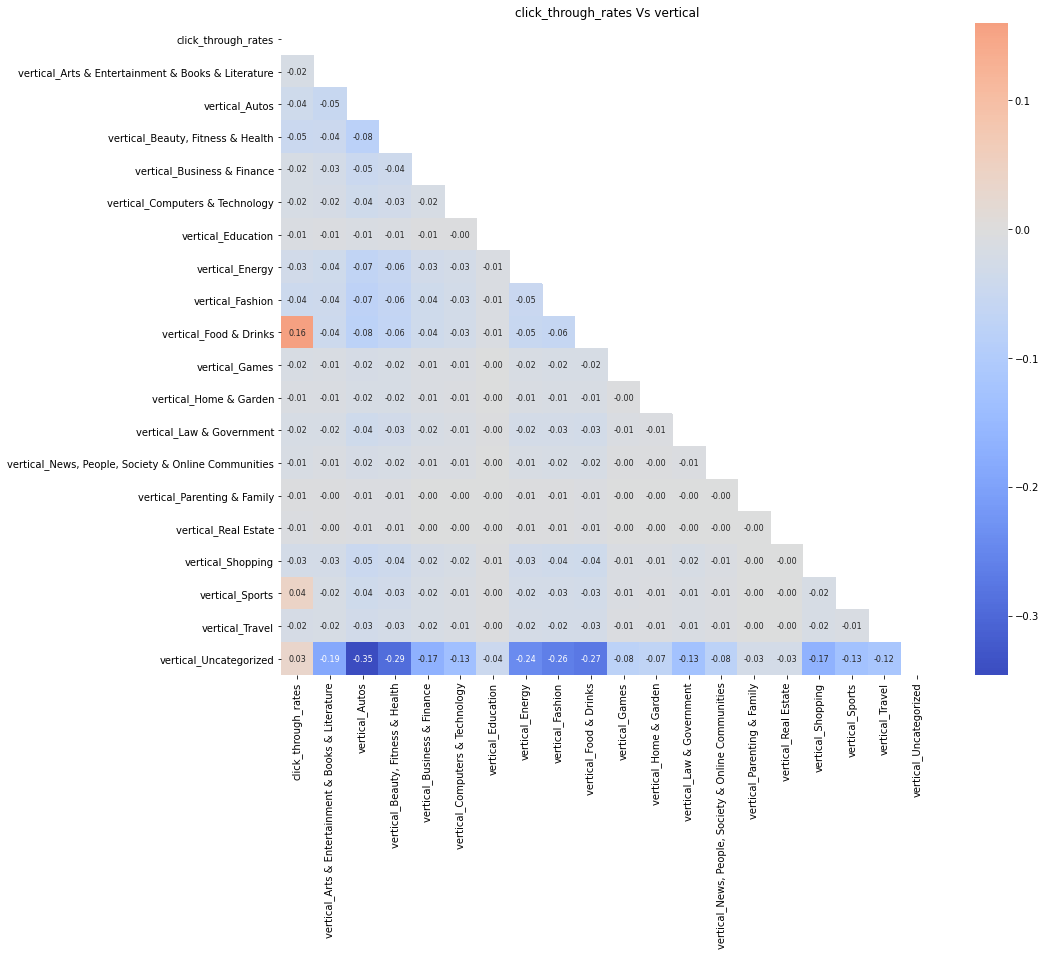

In [72]:
def draw_corr_matrix(data, category):
    """
    outputs a correlation matrix chart showing the diffrent 
    values and their correlation score
    
    Args:
        data - correlation data
    """
    # select data
    try:
        corr_data = data[['click_through_rates', category]]
        # get dummies
        corr_data_dummy = pd.get_dummies(corr_data)
        # compute correlation default computes the pearson
        corr_data_matrix = corr_data_dummy.corr()
        # create a mask
        mask = np.zeros_like(corr_data_matrix)
        mask[np.triu_indices_from(mask)] = True
        # plot chart
        plt.figure(figsize=(15, 12))
        plt.title(f'click_through_rates Vs {category}')
        sns.heatmap(corr_data_matrix, cmap='coolwarm', center=0, mask=mask, square=True, annot=True, annot_kws={'size':8}, fmt='.2f' )
        plt.show
    except Exception as e:
        print(f'Error Occured {e}')
    
draw_corr_matrix(df, 'vertical')

from the chart, the unique value **Food and Drinks** has the highest positive correlation score with the target with a score of 0.13. Since the Vertical categorical column has the highest correlation score with the click_through_rate, it can be said that the unique value **Food and Drinks** amount for that score.

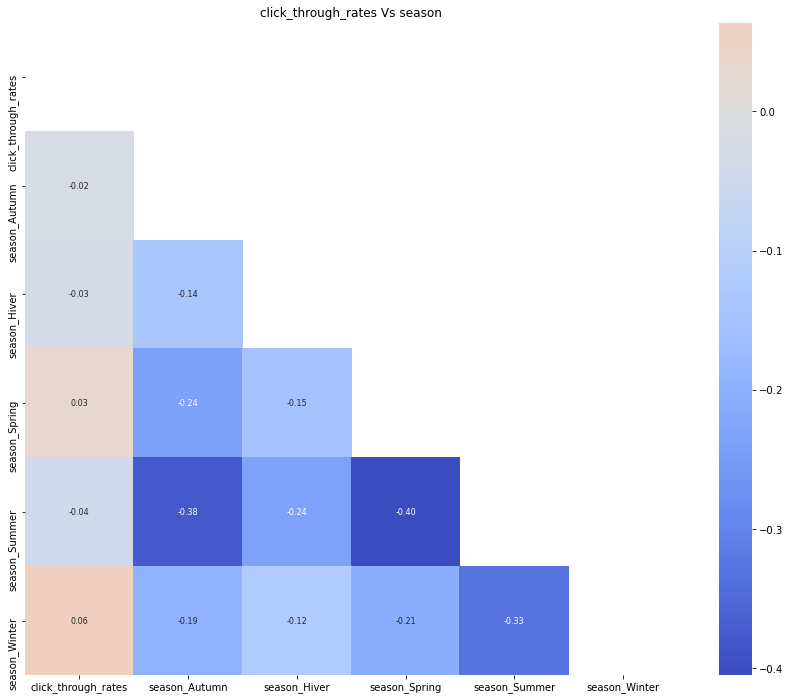

In [60]:
draw_corr_matrix(df, 'season')

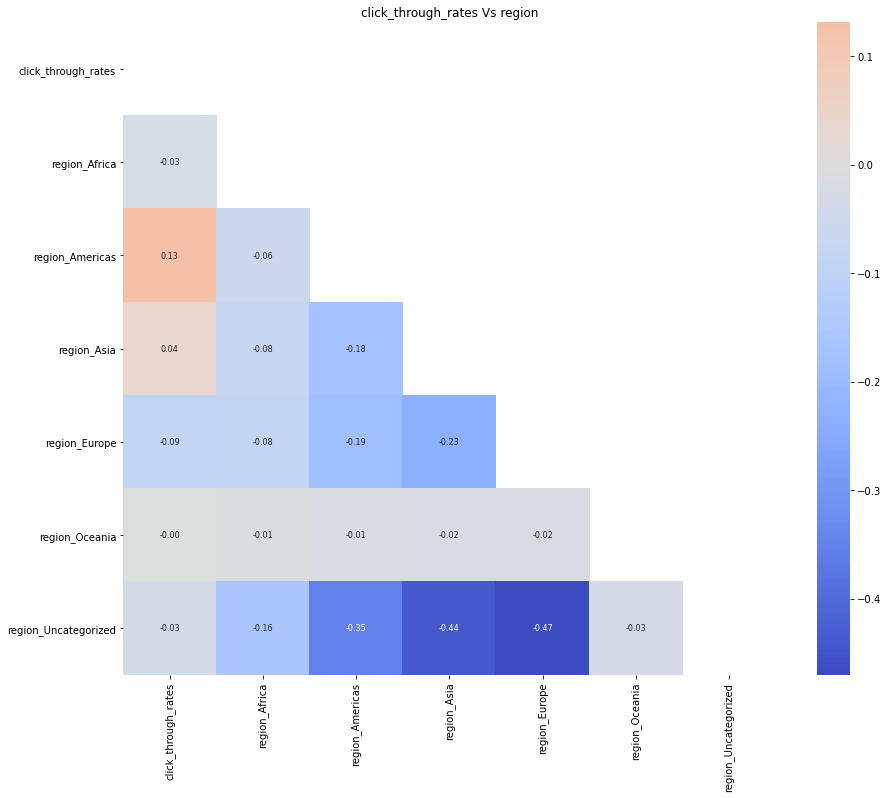

In [61]:
draw_corr_matrix(df, 'region')

In [69]:
corr_score

,click_through_rates
click_through_rates,1.000000
vertical_count,0.035575
season_count,-0.040185
region_count,-0.047147


The 2 most correlated columns with the click_through_rate are Vertical and Season, with some unique value contributing more to the correlation score.